## <font color='limegreen'>HIRING DEMAND FORECASTING</font>
### <font color='limegreen'>IV - MODEL DEPLOY</font>

In [1]:
# Python Language Version
from platform import python_version
print('The python version used in this jupyter notebook:', python_version())

The python version used in this jupyter notebook: 3.11.5


### 1. LOAD PACKAGES

#### Import packages

In [2]:
%%capture output
!pip install -q -r requirements.txt

In [3]:
from utils import *

In [4]:
# Packages versions
%reload_ext watermark
%watermark --iversions

platform     : 1.0.8
tensorflow   : 2.18.0
pandas       : 2.2.2
numpy        : 1.26.4
plotly       : 5.24.1
pymannkendall: 1.4.3
statsmodels  : 0.14.2
matplotlib   : 3.9.2
keras        : 3.8.0
seaborn      : 0.13.2
sklearn      : 1.5.1
torch        : 2.6.0
psycopg2     : 2.9.10 (dt dec pq3 ext lo64)
joblib       : 1.4.2
scipy        : 1.13.1



### 2. INFERÊNCIA/DEPLOY

In [5]:
# Load model and scaler
model = tf.keras.models.load_model('../models/lstm_model.keras')
scaler = joblib.load('../models/scaler.gz')

In [6]:
# Load historical data
df = pd.read_csv('../data/clean_data.csv')
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df.set_index('data', inplace=True)
df = df.asfreq('D')  

In [7]:
# Prepare input data
look_back = 30
contratacoes_30d = df['contratacoes'].values[-look_back:].reshape(-1, 1)
entrada_normalizada = scaler.transform(contratacoes_30d)

In [8]:
# Recursive forecast for 365 days
entrada = entrada_normalizada.copy()
previsoes = []

for _ in range(365):
    entrada_modelo = entrada[-look_back:].reshape((1, look_back, 1))
    pred = model.predict(entrada_modelo, verbose=0)
    previsoes.append(pred[0, 0])
    entrada = np.append(entrada, pred, axis=0)

In [9]:
# Revert normalization
previsoes = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1)).flatten()

In [10]:
# Create DataFrame with predictions
data_inicio = df.index[-1] + timedelta(days=1)
datas_futuras = pd.date_range(start=data_inicio, periods=365, freq='D')
df_previsao = pd.DataFrame({'data': datas_futuras, 'previsao_contratacoes': previsoes})
df_previsao.set_index('data', inplace=True)

In [11]:
df_previsao.head()

,previsao_contratacoes
data,
2025-03-01,130.030273
2025-03-02,139.312958
2025-03-03,198.244034
2025-03-04,226.474457
2025-03-05,241.642273


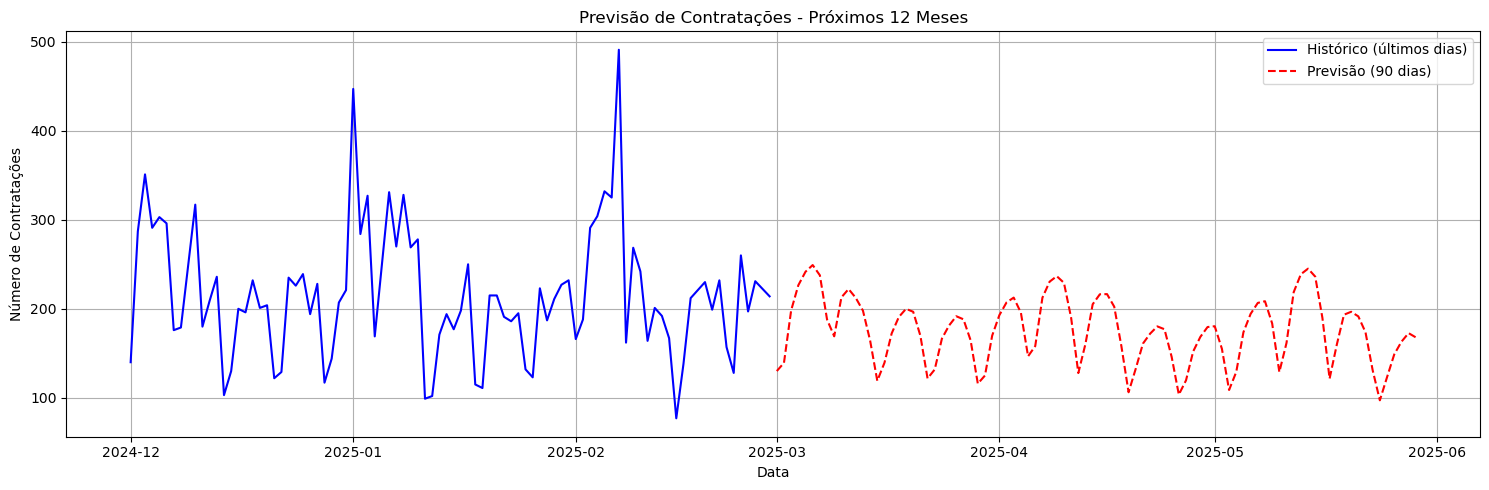

In [12]:
# Plot last 90 days + forecast
n_dias_plot = 90
plt.figure(figsize=(15, 5))
plt.plot(df.index[-n_dias_plot:], df['contratacoes'].iloc[-n_dias_plot:], label='Histórico (últimos dias)', color='blue')
plt.plot(df_previsao.index[:n_dias_plot], df_previsao['previsao_contratacoes'][:n_dias_plot], label=f'Previsão ({n_dias_plot} dias)', color='red', linestyle='--')
plt.title('Previsão de Contratações - Próximos 12 Meses')
plt.xlabel('Data')
plt.ylabel('Número de Contratações')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## END